<a href="https://colab.research.google.com/github/hariszaf/metabolic_toy_model/blob/main/Antony2025/gapfillingGSMMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gapfilling Genome-Scale Metabolic Models with DNNGIOR**

In [1]:
!pip install cobra
!pip install dnngior --no-deps

In [2]:
# @title
import os
def create_gurobi_license():
    license_content = (
        "# Gurobi WLS license file\n"
        "# Your credentials are private and should not be shared or copied to public repositories.\n"
        "# Visit https://license.gurobi.com/manager/doc/overview for more information.\n"
        "WLSACCESSID=1fedf73b-9471-4da8-bdc7-2aaacf2e30f3\n"
        "WLSSECRET=3bc7d209-a4ec-4195-98be-4b254f181512\n"
        "LICENSEID=940603"
    )
    with open("/content/licenses/gurobi.lic", "w") as f:
        f.write(license_content)
    print("License file created at /content/licenses/gurobi.lic")



# Create directory for the license
os.makedirs("/content/licenses", exist_ok=True)

# Generate the license file
create_gurobi_license()

#add to path
os.environ['GRB_LICENSE_FILE'] = '/content/licenses/gurobi.lic'

!pip install gurobipy

License file created at /content/licenses/gurobi.lic


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
cd /content/drive/MyDrive/Antony

/content/drive/MyDrive/Antony


### Gapfilling a model with a complete medium

Loading depencies

In [5]:
from cobra.io import read_sbml_model
from dnngior.gapfill_class import *
from dnngior.variables import *
from dnngior.NN_Predictor import NN
import pandas as pd

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 940603
Academic license 940603 - for non-commercial use only - registered to da___@gmail.com
The rest of dnngior features can be used without it.


Let's get the Bifidobacterium model we have been working with last time

In [6]:
path_to_draft_model = "Bifidobacterium adolescentis_atcc_15703.sbml"
draft_model = read_sbml_model(path_to_draft_model)
draft_model.summary()

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


If we want to gapfill on a complete medium and with the default NN, its actually quite simple. We can use the gapfill class of DNNGIOR giving the path to our draft model

In [7]:
gapfill_complete_medium = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1')
gf_model = gapfill_complete_medium.gapfilledModel

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.
ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Gap-filling database =  ModelSEED


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


#reactions not found in NN-keys:  65 / 726
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  79156 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  39578 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  19789 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  9894 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  4947 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  2473 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:

In [8]:
gf_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00028_e0,EX_cpd00028_e0,0.4434,34,0.07%
cpd00030_e0,EX_cpd00030_e0,0.4434,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.4434,0,0.00%
cpd00051_e0,EX_cpd00051_e0,11.91,6,0.34%
cpd00053_e0,EX_cpd00053_e0,358.2,5,8.58%
cpd00058_e0,EX_cpd00058_e0,0.4434,0,0.00%
cpd00060_e0,EX_cpd00060_e0,7.219,5,0.17%
cpd00063_e0,EX_cpd00063_e0,0.4434,0,0.00%
cpd00065_e0,EX_cpd00065_e0,3.355,11,0.18%
cpd00066_e0,EX_cpd00066_e0,10.85,9,0.47%


In [9]:
print("Number of reactions added:", len(gapfill_complete_medium.added_reactions))

Number of reactions added: 81


In principle this means we are done, let get a beer :)

But maybe you still want to learn something about how DNNGIOR works and what else we can do.

### How does DNNGIOR work

DNNGIOR gapfilling takes two steps:
1. Make a prediction based on the reactions in the draft model
2. Use these predictions to find weigh the solutions of the linear programming algorythm

Lets have a look at these predictions, we can load in the neural network:

In [10]:
NN_MSEED = NN(path=TRAINED_NN_MSEED)

and make a prediction for our model

In [11]:
prediction = NN_MSEED.predict(draft_model)

#reactions not found in NN-keys:  65 / 726


This will give us a prediction for what reactions should be present in the gapfilled model.

<Axes: ylabel='Frequency'>

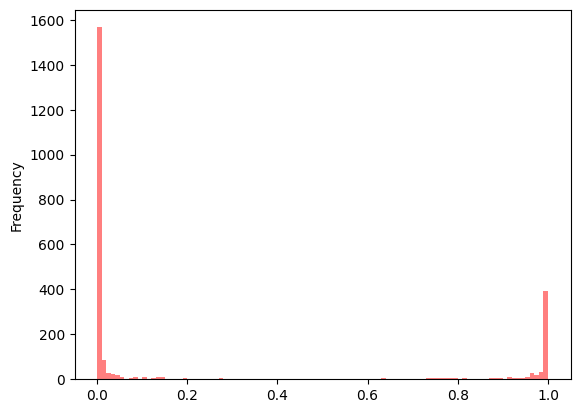

In [12]:
pd.Series(prediction).plot.hist(bins=100, alpha=0.5, color='r', label='MSEED')

These are part of the microbial reactome (all the reactions that were present), as the network cannot make predictions for reactions it has never seen it will not give a prediction for those. All other reactions will get the default cost which is normally set to 1.0 but can be changed if you want to prioritize reactions from the reactome:

In [13]:
gapfill_higher_def_cost = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1', default_cost=10, gapfill=False)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.
ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Gap-filling database =  ModelSEED


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


#reactions not found in NN-keys:  65 / 726


<Axes: ylabel='Frequency'>

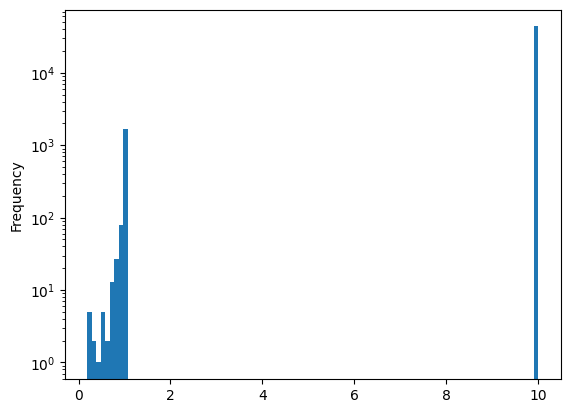

In [14]:
w = gapfill_higher_def_cost.weights
pd.Series(w).plot.hist(bins=100, label='Higher default cost', logy=True)

In [15]:
gapfill_higher_def_cost.gapfill()
print("Number of reactions added:", len(gapfill_higher_def_cost.added_reactions))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  79156 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  39578 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  19789 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  9894 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  4947 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  2473 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  1236 


Warning for adding constraints: z

## Gapfilling with a different medium

Often organisms dont grow in a complete medium, you can provide the gapfiller with a medium file

In [16]:
medium_file_path = 'DNNGIOR/docs/biochemistry/Nitrogen-Nitrite_media.tsv'

In [17]:
pd.read_csv(medium_file_path, sep='\t')

,id,name,concentration,minflux,maxflux
0,cpd00027,D-Glucose,0.001,-100,5
1,cpd00075,Nitrite,0.001,-100,5
2,cpd00009,Phosphate,0.001,-100,5
3,cpd00048,Sulfate,0.001,-100,5
4,cpd00063,Ca2+,0.001,-100,100
5,cpd00011,CO2,0.001,-100,0
6,cpd10516,fe3,0.001,-100,100
7,cpd00067,H+,0.001,-100,100
8,cpd00001,H2O,0.001,-100,100
9,cpd00205,K+,0.001,-100,100


In [18]:
gapfill_nit_medium = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1', medium_file = medium_file_path)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.
ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Gap-filling database =  ModelSEED


ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Loading medium from: DNNGIOR/docs/biochemistry/Nitrogen-Nitrite_media.tsv
#reactions not found in NN-keys:  4 / 665
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  76914 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  38457 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  19228 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  9614 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  4807 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  2403 


Warning for adding constraints:

In [19]:
gapfill_nit_medium.gapfilledModel.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00030_e0,EX_cpd00030_e0,0.3333,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.3333,0,0.00%
cpd00058_e0,EX_cpd00058_e0,0.3333,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.3333,0,0.00%
cpd00099_e0,EX_cpd00099_e0,0.3333,0,0.00%
cpd00205_e0,EX_cpd00205_e0,0.3333,0,0.00%
cpd00254_e0,EX_cpd00254_e0,0.3333,0,0.00%
cpd10515_e0,EX_cpd10515_e0,1,0,0.00%
cpd15560_e0,EX_cpd15560_e0,0.3333,49,100.00%
cpd17041_c0,rxn13782_c0,46.35,0,0.00%


Relevant to note is that using a more minimal medium tends to lead to a more gapfilled reactions as the models have to synthesize more compounds themselves

In [ ]:
print("Number of reactions added:", len(gapfill_nit_medium.added_reactions))

Number of reactions added: 198


### Batch gapfilling using the command line interface (CLI)

Finally in the case where you have a lot of models you want to gapfill with the same medium you can use the CLI

`python fasta2model_CLI.py -f DIR_FASTA -o output_folder`

This command will create an output folder (-o) containing a subfolder with base ungapfilled models, a subfolder with gapfilled models, a log, and a tsv file telling you the number of added reactions.

This CLI has limited functionality and assumes the same conditions for all gapfilling but you can change the standard gapfilling medium using the -e parameter.

`python fasta2model_CLI.py -f DIR_FASTA -o DIR_OUTPUT' -e PATH_TO_MEDIUM_FILE`

if you allready have base models you can use the -m parameter to provide a folder with base models to skip the base model building step.

`python fasta2model_CLI.py -m DIR_MODELS -o DIR_OUTPUT`

In [20]:
!python DNNGIOR/dnngior/fasta2model_CLI.py -m one_per_phylum_models -o one_per_phylum_gapfilled -e DNNGIOR/docs/biochemistry/Nitrogen-Nitrite_media.tsv -sm .sbml

# Creating output_folder for gapfilled models
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 940603
Academic license 940603 - for non-commercial use only - registered to da___@gmail.com
E0000 00:00:1741265521.533081    5908 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741265521.550368    5908 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The rest of dnngior features can be used without it.
Gap-filling database =  ModelSEED
Loading medium from: ./DNNGIOR/docs/biochemistry/Nitrogen-Nitrite_media.tsv
#reactions not found in NN-keys:  7 / 648
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000
Warning for adding constraints: zero or small (< 1e-13

This will take a while so maybe we should skip this or create a subset or let them continue

## For the interested: Customizing the candidate reaction scores





### Changing the Neural network

By default, dnngior uses its built-in neural network (NN) to predict which reactions should be added during gap filling. The gap-filler automatically assigns a cost of zero to reactions already present in the draft model, as well as to the exchange reactions defined in the media. For reactions not included in the NN-predicted reactome, a default high cost (set to 1) is applied, as these are considered less likely to occur.


In [ ]:
gapfill_Bigg = Gapfill('DNNGIOR/docs/models/bigg_example.xml', objectiveName='Growth', dbType='BiGG')

Gap-filling database =  BiGG


No objective coefficients in model. Unclear what should be optimized


#reactions not found in NN-keys:  1 / 530
of which are exchanges:  0
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000


 condition is currently:  54652 




 condition is currently:  27326 




 condition is currently:  13663 




 condition is currently:  6831 




 condition is currently:  3415 




 condition is currently:  1707 




 condition is currently:  853 




 condition is currently:  426 




 condition is currently:  213 




 condition is currently:  106 




 condition is currently:  53 




 condition is currently:  26 




 condition is currently:  13 




 condition is currently:  7 




 condition is currently:  3 




 condition is currently:  2 




 condition is currently:  1 


Objective value is 0.019842.
Read LP format model from file /tmp/tmp72ezq61j.lp
Reading time = 0.00 seconds
: 737 rows, 1338 columns, 6710 nonzeros
skipping refinement, not currently supported for BiGG models
NN gapfilling added 139 new reactions
The

The second customization option is to change the neural network (NN) used during gap filling. We will train our own network in the next part of the workshop. For now we can use an example provided, we made a couple neural networks tailored to some of the top phyla in docs/NN/custom_networks/.

To specify a custom NN, update the trainedNNPath parameter accordingly.

In [ ]:
dif_NN_gapfill = Gapfill(path_to_draft_model, trainedNNPath='DNNGIOR/docs/NN/custom_networks/Phylum_Actinobacteria.npz')

### Blacklisting reactions

You might want to exclude specific reactions from the gap-filling database (e.g. they are unbalanced or you know cannot be present based on other data), this can be done using the blacklist argument:

In [ ]:
blackList = ['rxn99999_c0']
gapfill_with_blacklist = Gapfill(path_to_draft_model, black_list = blackList, objectiveName = 'bio1')

Sometimes reactions are unavoidable (i.e. no solution can be found without them), but you want as few of them as possible. You could manually set the weights of these reactions (see below) but to make it easier you can set a grey list. By default these reactions get a cost of 1,000 but you can change this using punish_cost.

In [ ]:
greyList = ['rxn04070_c0','rxn05467_c0','rxn00543_c0']
gapfill_with_greylist = Gapfill(path_to_draft_model, grey_list = greyList, punish_cost = 5000, objectiveName = 'bio1')

### Custom scores

The final option is to use fully custom scores. This is by far the most, you can make any changes to any reaction you want. To make these changes it is useful to set the gapfill parameter to False. This stops the gapfilling class from automatically continuing to the gapfilling step.

In [ ]:
ungapfilled_model = Gapfill(draftModel = path_to_draft_model, gapfill=False)

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


Gap-filling database =  ModelSEED


No objective coefficients in model. Unclear what should be optimized


#reactions not found in NN-keys:  65 / 726
of which are exchanges:  61


Then you can change your candidates using the set_weights function

In [ ]:
import json
s_file = open(os.path.join('DNNGIOR', 'docs', 'NN','single_example.json'))
scores = json.loads(s_file.read())
s_file.close()

ungapfilled_model.set_weights(scores)

or manually set reactions directly

In [ ]:
ungapfilled_model.weights['rnx0001'] = 0.4

reloading your model will reset them back to the NN-predicted weights but there is also a function for this:

In [ ]:
ungapfilled_model.reset_weights()

#reactions not found in NN-keys:  65 / 726
of which are exchanges:  61


Once you are ready to continue the gapfilling, you can use the class function gapfill() to resume the gap-filling process

In [ ]:
ungapfilled_model.gapfill()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Flux through biomass reaction is 1.00000000
Flux through biomass reaction is 1.00000000
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  79817 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  39908 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  19954 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  9977 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  4988 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  2494 


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


 condition is currently:  1247 


Warning for adding constraints: z

Name,_gapfilled
Memory address,7feb32abd330
Number of metabolites,801
Number of reactions,831
Number of genes,529
Number of groups,0
Objective expression,1.0*bio1 - 1.0*bio1_reverse_b18f7
Compartments,"c0, e0"
